In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('dataset music/data_playcount.csv')

users = df['id_user'].values
tracks = df['id_track'].values
initial_playcounts = df['count'].values
playcounts = 1 + (initial_playcounts - 1) * (5 - 1) / (50 - 1)
print(playcounts)


uniques = [np.unique(users).shape[0], np.unique(tracks).shape[0]]

print('number of unique users:', uniques[0])
print('number of unique tracks:', uniques[1])
print('number of playcounts:', users.shape[0])
print('total number of cells:', uniques[0] * uniques[1])
print('Ratio of entries filled:', users.shape[0]/(uniques[0] * uniques[1]))


[5.         5.         4.10204082 ... 1.         1.         1.        ]
number of unique users: 11
number of unique tracks: 67241
number of playcounts: 125763
total number of cells: 739651
Ratio of entries filled: 0.17003018991389182


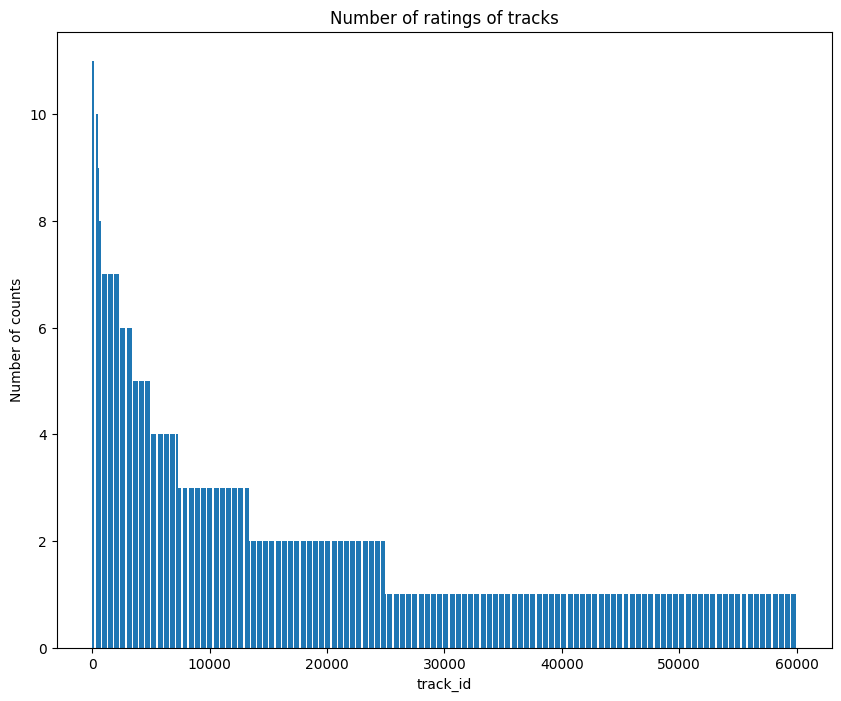

In [60]:
track_uniques = np.unique(tracks)

track_occurances = []
for track in track_uniques:
    occ = np.count_nonzero(tracks == track)
    track_occurances.append(occ)
track_occurances = np.array(track_occurances)

sort_indices = np.argsort(track_occurances) 

track_uniques_occ_sorted = track_uniques[sort_indices]
track_uniques_occ_sorted = track_uniques_occ_sorted[::-1]
track_uniques_occ_sorted = np.array(track_uniques_occ_sorted)

track_occurances_sorted = track_occurances[sort_indices]
track_occurances_sorted = track_occurances_sorted[::-1]

plt.figure(figsize=(10,8))
plt.bar(range(len(track_occurances_sorted[0:60000])), track_occurances_sorted[:60000])
plt.title('Number of ratings of tracks')
plt.xlabel('track_id')
plt.ylabel('Number of counts')
plt.show()

In [61]:
M = np.zeros((uniques[0], uniques[1]))
mask = np.zeros(M.shape)
for u, t, c in zip(users, tracks, playcounts):
    M[u, np.where(track_uniques_occ_sorted == t)[0][0]]= c
    mask[u, np.where(track_uniques_occ_sorted == t)[0][0]]= 1.
     
print(np.sum(mask))

125763.0


In [62]:
test_count = 60000
_is = np.random.randint(0, len(users), test_count)
 
test_mask = np.zeros(M.shape)
for i in _is:
    _user = users[i]
    _track = np.where(track_uniques_occ_sorted == tracks[i])[0][0]
    test_mask[_user, _track] = 1
     
print(np.sum(test_mask))

47691.0


In [63]:
cutoff = 30000
M = tf.constant(M[:, :cutoff], dtype=tf.float32)
mask = tf.cast(mask[:, :cutoff], dtype=tf.float32)  
test_mask = tf.cast(test_mask[:, :cutoff], dtype=tf.float32)
train_mask = mask - test_mask

print('Number of testing:', tf.reduce_sum(test_mask))
print('Number of training:', tf.reduce_sum(train_mask))


Number of testing: tf.Tensor(33626.0, shape=(), dtype=float32)
Number of training: tf.Tensor(54896.0, shape=(), dtype=float32)


In [64]:
def early_stopping(losses, patience = 5):
     
    if len(losses) <= patience + 1:
        return False
     
    avg_loss = np.mean(losses[-1 - patience:-1])
     
    if avg_loss - losses[-1] < 0.01*avg_loss:
        return True
     
    return False

In [65]:
def train(k):
    U_d = tf.Variable(tf.random.normal((11, k)))
    V_d = tf.Variable(tf.random.normal((k, cutoff)))
    
    train_norm = tf.reduce_sum(train_mask)
    test_norm = tf.reduce_sum(test_mask)
    
    adam_opt = tf.keras.optimizers.Adam()
    from datetime import datetime
    lr = 0.001
    ep = 0
    start_time = datetime.now()
    train_losses = []
    test_losses = []
    
    while True:
        with tf.GradientTape() as tape:
            M_app = U_d @ V_d
            pred_errors_squared = tf.square(M - M_app)
            train_loss = tf.reduce_sum((train_mask * pred_errors_squared)/train_norm)
        test_loss = tf.reduce_sum((test_mask * pred_errors_squared) / test_norm)
    
        if ep%100 == 0:
            print(datetime.now() - start_time, train_loss, test_loss, ep)
            train_losses.append(train_loss.numpy())
            test_losses.append(test_loss.numpy())
        if early_stopping(train_losses):
            break
            
        grads = tape.gradient(train_loss, [U_d, V_d])
        adam_opt.apply_gradients(zip(grads, [U_d, V_d]))
    
        ep += 1

    return train_losses, test_losses, U_d, V_d
    


In [66]:
train_losses, test_losses, U_d, V_d = train(2)

0:00:00.006677 tf.Tensor(2.9037328, shape=(), dtype=float32) tf.Tensor(2.8989675, shape=(), dtype=float32) 0
0:00:02.516920 tf.Tensor(2.3368914, shape=(), dtype=float32) tf.Tensor(2.4960527, shape=(), dtype=float32) 100
0:00:04.844107 tf.Tensor(1.9521462, shape=(), dtype=float32) tf.Tensor(2.2228036, shape=(), dtype=float32) 200
0:00:07.219610 tf.Tensor(1.6720287, shape=(), dtype=float32) tf.Tensor(2.0225873, shape=(), dtype=float32) 300
0:00:09.698696 tf.Tensor(1.4535285, shape=(), dtype=float32) tf.Tensor(1.8638287, shape=(), dtype=float32) 400
0:00:11.998318 tf.Tensor(1.2713658, shape=(), dtype=float32) tf.Tensor(1.7260363, shape=(), dtype=float32) 500
0:00:14.414930 tf.Tensor(1.1087787, shape=(), dtype=float32) tf.Tensor(1.5965825, shape=(), dtype=float32) 600
0:00:16.887721 tf.Tensor(0.9559745, shape=(), dtype=float32) tf.Tensor(1.470628, shape=(), dtype=float32) 700
0:00:19.165550 tf.Tensor(0.81059486, shape=(), dtype=float32) tf.Tensor(1.3482685, shape=(), dtype=float32) 800
0:0

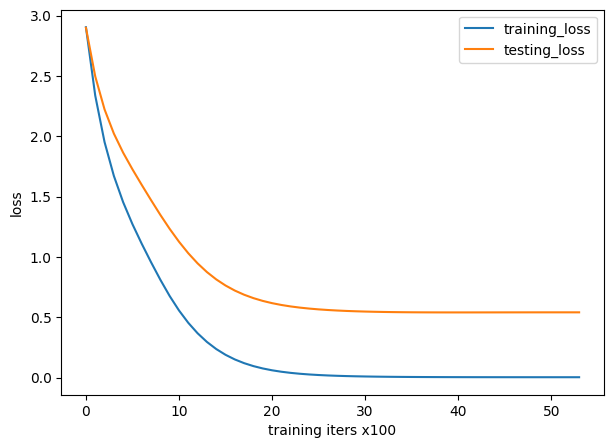

In [67]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(test_losses, label = 'testing_loss')
plt.xlabel('training iters x100')
plt.ylabel('loss')
plt.legend()
plt.show()

In [68]:
M_pred = tf.matmul(U_d, V_d)
M_pred


<tf.Tensor: shape=(11, 30000), dtype=float32, numpy=
array([[1.0535263 , 1.044169  , 1.0187716 , ..., 1.0337878 , 1.0038134 ,
        1.0188272 ],
       [1.0539168 , 1.0342889 , 1.0408602 , ..., 1.0001631 , 1.0000151 ,
        1.0000492 ],
       [1.0300555 , 1.0108929 , 1.0172503 , ..., 0.9775882 , 0.97738284,
        0.97744656],
       ...,
       [0.9775913 , 0.96619904, 0.9510709 , ..., 0.9503012 , 0.930361  ,
        0.94033813],
       [0.9227421 , 0.9449674 , 0.827974  , ..., 1.0062171 , 0.8915567 ,
        0.94910717],
       [1.0047538 , 0.98500454, 0.99449915, ..., 0.9500728 , 0.9529455 ,
        0.9514644 ]], dtype=float32)>

In [69]:
pd.DataFrame(M_pred)

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,1.053526,1.044169,1.018772,1.055251,1.039439,1.081438,1.057403,1.062743,1.035472,1.056887,...,1.098624,1.526616,0.883717,0.971282,1.011653,-1.329831,-0.058519,1.033788,1.003813,1.018827
1,1.053917,1.034289,1.040860,1.025372,1.040206,1.063251,1.036271,1.050171,1.044775,1.033917,...,1.081659,1.518021,0.882526,0.999490,1.000033,-1.323636,-0.025707,1.000163,1.000015,1.000049
2,1.030056,1.010893,1.017250,1.002218,1.016655,1.039216,1.012853,1.026421,1.021103,1.010556,...,1.057205,1.483671,0.862548,0.976804,0.977416,-1.293682,-0.025192,0.977588,0.977383,0.977447
3,1.026621,1.008953,1.010834,1.003095,1.013212,1.038341,1.012476,1.024805,1.016456,1.010442,...,1.056101,1.480001,0.859884,0.969667,0.975829,-1.290301,-0.029683,0.979068,0.974705,0.976857
4,1.040192,1.020584,1.027803,1.011325,1.026669,1.048978,1.022283,1.036198,1.031374,1.019917,...,1.067175,1.498043,0.870998,0.987112,0.986735,-1.306246,-0.024620,0.986359,0.986897,0.986587
5,1.020526,0.996737,1.017997,0.978783,1.007427,1.020904,0.993413,1.010858,1.015830,0.990276,...,1.039296,1.465659,0.853857,0.980796,0.962761,-1.278584,-0.009597,0.952633,0.966389,0.959441
6,0.981714,0.968457,0.958922,0.969944,0.968756,0.999509,0.975815,0.984573,0.968831,0.974522,...,1.016061,1.418508,0.822808,0.917381,0.937394,-1.236229,-0.040021,0.948293,0.933547,0.940915
7,0.976259,0.967126,0.945030,0.976495,0.963223,1.001288,0.978883,0.984217,0.959930,0.978323,...,1.017268,1.414240,0.818836,0.901300,0.936917,-1.231999,-0.052750,0.956439,0.930005,0.943243
8,0.977591,0.966199,0.951071,0.971203,0.964620,0.998586,0.975509,0.982722,0.963192,0.974545,...,1.014854,1.414165,0.819621,0.908624,0.935570,-1.232216,-0.045637,0.950301,0.930361,0.940338
9,0.922742,0.944967,0.827974,1.013941,0.909273,1.002266,0.989910,0.969234,0.880499,0.994906,...,1.013714,1.364245,0.778515,0.768199,0.921606,-1.184562,-0.148538,1.006217,0.891557,0.949107


In [70]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(M_pred)
print(user_similarity)

[[0.99999845 0.9998695  0.9998684  0.9999029  0.999861   0.9997088
  0.99996924 0.99999875 0.9999887  0.9985164  0.99983805]
 [0.9998695  1.000005   1.0000029  0.9999999  1.0000026  0.9999716
  0.9999657  0.9998829  0.9999348  0.99750257 1.0000014 ]
 [0.9998684  1.0000029  1.0000014  0.99999857 1.0000011  0.99997014
  0.9999643  0.99988174 0.9999334  0.99750334 0.99999976]
 [0.9999029  0.9999999  0.99999857 1.0000001  0.99999666 0.9999483
  0.999981   0.99991405 0.99995714 0.99766433 0.99999213]
 [0.999861   1.0000026  1.0000011  0.99999666 1.0000002  0.9999726
  0.9999603  0.99987453 0.9999282  0.9974739  0.9999999 ]
 [0.9997088  0.9999716  0.99997014 0.9999483  0.9999726  1.0000001
  0.99986553 0.999728   0.9998106  0.9969153  0.99998194]
 [0.99996924 0.9999657  0.9999643  0.999981   0.9999603  0.99986553
  0.9999994  0.99997586 0.99999523 0.99806803 0.9999476 ]
 [0.99999875 0.9998829  0.99988174 0.99991405 0.99987453 0.999728
  0.99997586 1.         0.9999926  0.99847394 0.99985266]

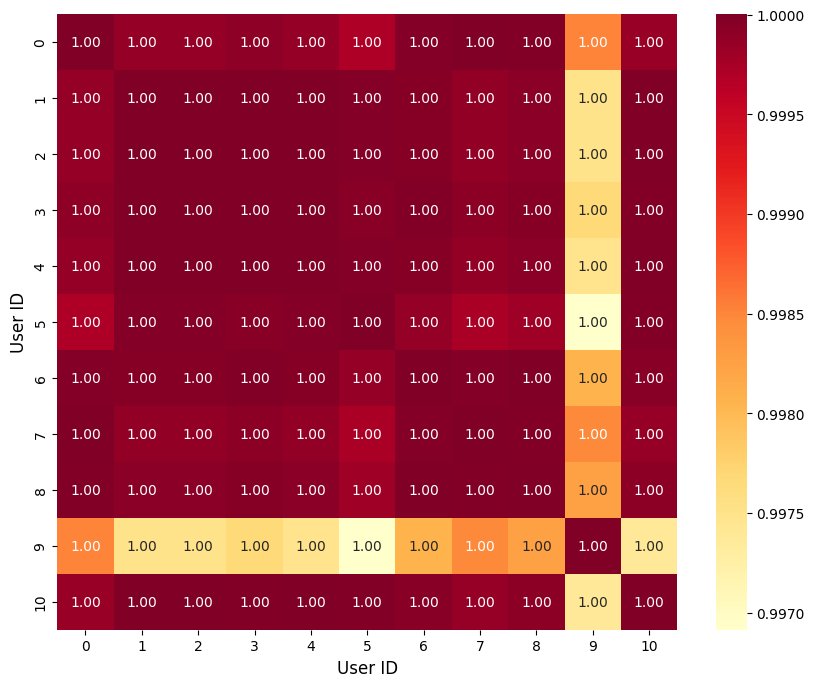

In [71]:
import seaborn as sns

# Vẽ heatmap
plt.figure(figsize=(10, 8))  # Đặt kích thước biểu đồ
sns.heatmap(
    user_similarity,
    annot=True,  # Hiển thị giá trị trong các ô
    fmt=".2f",  # Định dạng số thập phân
    cmap="YlOrRd",  # Màu sắc của heatmap
    xticklabels=range(user_similarity.shape[0]),  # Nhãn trục x (User ID)
    yticklabels=range(user_similarity.shape[1]),  # Nhãn trục y (User ID)
)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("User ID", fontsize=12)

# Hiển thị biểu đồ
plt.show()

In [72]:
users = pd.read_csv('dataset music/users.csv')
tracks = pd.read_csv('dataset music/tracks.csv')

In [73]:
def recommendation(user, top_n=10):
    # Tìm ID của user
    user_row = users[users['Username'] == user]['index']
    
    if user_row.empty:
        print("User không tồn tại!")
        return
    
    user_id = user_row.values[0]  # Lấy giá trị đầu tiên
    
    # --- Gợi ý từ ma trận dự đoán M_pred ---
    # Lấy top N bài hát được đề xuất từ M_pred
    top_recommendations = np.argsort(-M_pred[user_id])[:top_n]
    
    # --- Gợi ý từ người dùng tương đồng ---
    # Tìm những người dùng tương đồng nhất (bỏ qua chính người dùng đó)
    similar_users = np.argsort(-user_similarity[user_id])[1:top_n + 1]  # Lấy top N người dùng tương đồng
    
    # Lấy các bài hát mà những người dùng tương đồng đã nghe
    similar_users_recommendations = set()
    for similar_user_id in similar_users:
        # Lấy các bài hát mà người dùng tương đồng đã nghe (có đánh giá > 0 trong M_pred)
        similar_user_tracks = np.where(M_pred[similar_user_id] > 0)[0]
        similar_users_recommendations.update(similar_user_tracks)
    
    # Loại bỏ các bài hát mà người dùng hiện tại đã nghe
    user_tracks = np.where(M_pred[user_id] > 0)[0]
    similar_users_recommendations = similar_users_recommendations - set(user_tracks)
    
    # --- Kết hợp hai danh sách gợi ý ---
    # Tạo một từ điển để lưu trữ bài hát và điểm số tổng hợp
    track_scores = {}
    
    # Thêm điểm từ ma trận dự đoán
    for track_id in top_recommendations:
        track_scores[track_id] = M_pred[user_id][track_id]
    
    # Thêm điểm từ những người dùng tương đồng
    for track_id in similar_users_recommendations:
        if track_id in track_scores:
            track_scores[track_id] += 1  # Tăng điểm nếu bài hát đã có trong danh sách
        else:
            track_scores[track_id] = 1  # Thêm bài hát mới vào danh sách
    
    # Sắp xếp các bài hát theo điểm số từ cao xuống thấp
    sorted_tracks = sorted(track_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Lấy top N bài hát
    top_combined_recommendations = [track_id for track_id, _ in sorted_tracks[:top_n]]
    
    # In ra các bài hát được đề xuất
    print(f"Top {top_n} gợi ý kết hợp cho user {user}:")
    for track_id in top_combined_recommendations:
        track_row = tracks[tracks['index'] == track_id]['Track']
        if not track_row.empty:
            print(track_row.values[0])
        else:
            print(f"Không tìm thấy bài hát có index {track_id}")

In [74]:
recommendation('Babs_05')

Top 10 gợi ý kết hợp cho user Babs_05:
Oasis
Don't Wanna Know (feat. Kendrick Lamar)
Festival of the Flowers
Aneurysm
Runnin' Away - single master
Bailão
Polarize
Disco Inferno - Single Edit
Green Calx
Barzinho Aleatório - Ao Vivo
